# Parameter recovery - Hybrid model (HM (I)P+S (E)P+S 2beta)
**Florian Ott, 2022**

Here we perform a parameter recovery analysis to test whether the parameters of the model HM are identifiable. We first generate simulated data with a set of known parameters and then fit the model to the simulated data. If the estimated parameters match the known parameters, the model works as intended.

In [3]:
import glob as glob
import pickle as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('./ara.mplstyle')
import scipy.stats as stats
import pystan

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#%% Load behavioural data 
filename = glob.glob('../data/behaviour/data_all_participants_20220215120148.csv')
dat = pd.read_csv(filename[0],index_col = 0)

#%% Load model data
# Posterior mean and credibility intervals of estimated parameters
with open('../data/model/summary_HM_20220216143030.pkl', 'rb') as f:
    summary_hybrid = pickle.load(f)['summary']

## Simulate novel responses

Here we use posterior means of individual and group level parameters to simulate novel data.

In [4]:
#%% Simulate novel data for refitting 
is_full_energy_rep = dat['is_full_energy'].to_numpy(dtype='int').squeeze()
is_low_energy_LC_rep = dat['is_low_energy_LC'].to_numpy(dtype='int').squeeze()
is_low_energy_HC_rep = dat['is_low_energy_HC'].to_numpy(dtype='int').squeeze()
is_basic_1_rep = dat['is_basic_1'].to_numpy(dtype='int').squeeze()
is_basic_2_rep = dat['is_basic_2'].to_numpy(dtype='int').squeeze()
is_basic_3_rep = dat['is_basic_3'].to_numpy(dtype='int').squeeze()
is_basic_4_rep = dat['is_basic_4'].to_numpy(dtype='int').squeeze()
is_basic_rep = dat['is_basic'].to_numpy(dtype='int').squeeze()
dv_rep = dat['dv_planning'].to_numpy().squeeze()
is_23_rep = dat['is_23'].to_numpy().squeeze()
is_14_rep = dat['is_14'].to_numpy().squeeze()

# Get posterior mean of group and individual paramters 
tpp = 240 # Number of trials per participant
beta_dv_23_rep = np.repeat(summary_hybrid['beta_dv_23']['mean'].to_numpy(),tpp)
beta_dv_14_rep = np.repeat(summary_hybrid['beta_dv_14']['mean'].to_numpy(),tpp)
theta_basic_1_rep = np.repeat(summary_hybrid['theta_basic_1']['mean'].to_numpy(),tpp)
theta_basic_2_rep = np.repeat(summary_hybrid['theta_basic_2']['mean'].to_numpy(),tpp)
theta_basic_3_rep = np.repeat(summary_hybrid['theta_basic_3']['mean'].to_numpy(),tpp)
theta_basic_4_rep = np.repeat(summary_hybrid['theta_basic_4']['mean'].to_numpy(),tpp)
theta_full_energy_rep = summary_hybrid['theta_full_energy']['mean'].to_numpy()
theta_low_energy_HC_rep = summary_hybrid['theta_low_energy_HC']['mean'].to_numpy()
theta_low_energy_LC_rep = summary_hybrid['theta_low_energy_LC']['mean'].to_numpy()

# Sample novel binary responses based on posterior mean parameter values
logits_rep = theta_full_energy_rep * is_full_energy_rep + theta_low_energy_LC_rep * is_low_energy_LC_rep + theta_low_energy_HC_rep * is_low_energy_HC_rep + theta_basic_1_rep * is_basic_1_rep + theta_basic_2_rep * is_basic_2_rep + theta_basic_3_rep * is_basic_3_rep + theta_basic_4_rep * is_basic_4_rep + beta_dv_23_rep * dv_rep * is_23_rep +  beta_dv_14_rep * dv_rep * is_14_rep
p_rep = sigmoid(logits_rep) 
response_rep = stats.bernoulli.rvs(p_rep)

## Specifying the model

In [5]:
m03 = '''
data {
  int<lower=0> N;
  int<lower=0,upper=1> response[N];
  vector[N] dv;
  vector[N] is_basic_1;
  vector[N] is_basic_2;
  vector[N] is_basic_3;
  vector[N] is_basic_4;
  vector[N] is_23;
  vector[N] is_14;
  vector[N] is_full_energy;
  vector[N] is_low_energy_LC;
  vector[N] is_low_energy_HC;
  int<lower=0> N_subjects;
  int<lower = 1> vpn[N];  
}

parameters {
// hyper paramters 
  real mu_theta_basic_1;
  real mu_theta_basic_2;
  real mu_theta_basic_3;
  real mu_theta_basic_4;
  real mu_beta_dv_23;  
  real mu_beta_dv_14;  
  real<lower=0> sigma_theta_basic_1;
  real<lower=0> sigma_theta_basic_2;
  real<lower=0> sigma_theta_basic_3;
  real<lower=0> sigma_theta_basic_4;
  real<lower=0> sigma_beta_dv_23;
  real<lower=0> sigma_beta_dv_14;


// parameters
  vector[N_subjects] theta_basic_1;
  vector[N_subjects] theta_basic_2;
  vector[N_subjects] theta_basic_3;
  vector[N_subjects] theta_basic_4;
  real theta_full_energy;
  real theta_low_energy_LC;
  real theta_low_energy_HC;
  vector[N_subjects] beta_dv_23;
  vector[N_subjects] beta_dv_14;

}

model {
//hyper priors
  mu_theta_basic_1 ~ normal(0,2);
  mu_theta_basic_2 ~ normal(0,2);
  mu_theta_basic_3 ~ normal(0,2);
  mu_theta_basic_4 ~ normal(0,2);
  mu_beta_dv_23 ~ normal(0,2);
  mu_beta_dv_14 ~ normal(0,2);  
  sigma_theta_basic_1 ~ normal(0,2);
  sigma_theta_basic_2 ~ normal(0,2);
  sigma_theta_basic_3 ~ normal(0,2);
  sigma_theta_basic_4 ~ normal(0,2);
  sigma_beta_dv_23 ~ normal(0,2);
  sigma_beta_dv_14 ~ normal(0,2);

// priors
  theta_basic_1 ~ normal(mu_theta_basic_1,sigma_theta_basic_1);
  theta_basic_2 ~ normal(mu_theta_basic_2,sigma_theta_basic_2);
  theta_basic_3 ~ normal(mu_theta_basic_3,sigma_theta_basic_3);
  theta_basic_4 ~ normal(mu_theta_basic_4,sigma_theta_basic_4);
  theta_full_energy ~ normal(0,2);
  theta_low_energy_LC ~ normal(0,2);
  theta_low_energy_HC ~ normal(0,2);
  beta_dv_23 ~ normal(mu_beta_dv_23,sigma_beta_dv_23);  
  beta_dv_14 ~ normal(mu_beta_dv_14,sigma_beta_dv_14);  

// likelihood 
  response ~ bernoulli_logit(theta_full_energy * is_full_energy + theta_low_energy_LC * is_low_energy_LC + theta_low_energy_HC * is_low_energy_HC + theta_basic_1[vpn] .* is_basic_1 + theta_basic_2[vpn] .* is_basic_2 + theta_basic_3[vpn] .* is_basic_3 + theta_basic_4[vpn] .* is_basic_4 + beta_dv_23[vpn] .* dv .* is_23 + beta_dv_14[vpn] .* dv .* is_14);
}

generated quantities {
  vector[N] log_lik;
  vector[N] response_new;
  vector[N_subjects] theta_basic_1_rep;
  vector[N_subjects] theta_basic_2_rep;
  vector[N_subjects] theta_basic_3_rep;
  vector[N_subjects] theta_basic_4_rep;
  vector[N_subjects] beta_dv_rep_23;
  vector[N_subjects] beta_dv_rep_14;


// pointwise log-likelihood
  for (n in 1:N) {
    log_lik[n] = bernoulli_logit_lpmf(response[n]  |  (theta_full_energy * is_full_energy[n] + theta_low_energy_LC * is_low_energy_LC[n] + theta_low_energy_HC * is_low_energy_HC[n] + theta_basic_1[vpn[n]] * is_basic_1[n] + theta_basic_2[vpn[n]] * is_basic_2[n] + theta_basic_3[vpn[n]] * is_basic_3[n] + theta_basic_4[vpn[n]] * is_basic_4[n] + beta_dv_23[vpn[n]] * dv[n] * is_23[n] + beta_dv_14[vpn[n]] * dv[n] * is_14[n]));
    }

// posterior predictive simulation  
  for (n in 1:N_subjects){
    theta_basic_1_rep[n] = normal_rng(mu_theta_basic_1, sigma_theta_basic_1);
    theta_basic_2_rep[n] = normal_rng(mu_theta_basic_2, sigma_theta_basic_2);
    theta_basic_3_rep[n] = normal_rng(mu_theta_basic_3, sigma_theta_basic_3);
    theta_basic_4_rep[n] = normal_rng(mu_theta_basic_4, sigma_theta_basic_4);
    beta_dv_rep_23[n] = normal_rng(mu_beta_dv_23, sigma_beta_dv_23);
    beta_dv_rep_14[n] = normal_rng(mu_beta_dv_14, sigma_beta_dv_14);

    }  

  for (n in 1:N){
    response_new[n] = bernoulli_logit_rng(theta_full_energy * is_full_energy[n] + theta_low_energy_LC * is_low_energy_LC[n] + theta_low_energy_HC * is_low_energy_HC[n] + theta_basic_1_rep[vpn[n]] * is_basic_1[n] + theta_basic_2_rep[vpn[n]] * is_basic_2[n] + theta_basic_3_rep[vpn[n]] * is_basic_3[n] + theta_basic_4_rep[vpn[n]] * is_basic_4[n] + beta_dv_rep_23[vpn[n]] * dv[n] * is_23[n] + beta_dv_rep_14[vpn[n]] * dv[n] * is_14[n]);
    } 
}
'''

## Compiling

In [6]:
sm03 = pystan.StanModel(model_code=m03,verbose = False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e96711c7616c1e7d3db6e6183c21a3cb NOW.


## Specifying the data

In [7]:
dat['response_rep'] = response_rep
idx = (dat['timeout'] == 0)
response = (dat.loc[idx,['response_rep']]).to_numpy(dtype='int').squeeze()
is_full_energy = dat.loc[idx,['is_full_energy']].to_numpy(dtype='int').squeeze()
is_low_energy_LC = dat.loc[idx,['is_low_energy_LC']].to_numpy(dtype='int').squeeze()
is_low_energy_HC = dat.loc[idx,['is_low_energy_HC']].to_numpy(dtype='int').squeeze()
is_basic_1 = dat.loc[idx,['is_basic_1']].to_numpy(dtype='int').squeeze()
is_basic_2 = dat.loc[idx,['is_basic_2']].to_numpy(dtype='int').squeeze()
is_basic_3 = dat.loc[idx,['is_basic_3']].to_numpy(dtype='int').squeeze()
is_basic_4 = dat.loc[idx,['is_basic_4']].to_numpy(dtype='int').squeeze()
is_14 = dat.loc[idx,['is_14']].to_numpy(dtype='int').squeeze()
is_23 = dat.loc[idx,['is_23']].to_numpy(dtype='int').squeeze()
vpn = dat.loc[idx,['vpn']].to_numpy().squeeze() - 100
N_subjects = len(np.unique(vpn))
dv = dat.loc[idx,['dv_planning']].to_numpy().squeeze()

dat_dict  = {'N':len(response),         
            'response':response,
            'dv':dv,      
            'is_full_energy':is_full_energy ,
            'is_low_energy_LC':is_low_energy_LC,
            'is_low_energy_HC':is_low_energy_HC,
            'is_basic_1':is_basic_1,
            'is_basic_2':is_basic_2,
            'is_basic_3':is_basic_3,
            'is_basic_4':is_basic_4,
            'is_23':is_23,
            'is_14':is_14,
            'N_subjects':N_subjects,
            'vpn':vpn
            } 

## Sampling posterior

Refitting the model with the simulated data.

In [8]:
res_sm03 = sm03.sampling(data=dat_dict, iter=8000,  warmup=4000, thin=1, chains=4,control = dict(adapt_delta=0.99),seed=101, verbose = False);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Summarize results

In [9]:
samples_rep = res_sm03.extract(pars=res_sm03.model_pars,permuted=True,inc_warmup = False) # extract permuted variables after warmup
param_names = res_sm03.model_pars

unique_vpns = np.unique(dat['vpn'])
ns = len(unique_vpns)

# Summarize paramter samples 
summary_rep = {}
for i,param in enumerate(param_names):
    df_tmp = pd.DataFrame([])

    if (np.ndim(samples_rep[param]) > 1 ):
        if (np.size(samples_rep[param],axis = 1) == ns):
                   df_tmp['mean'] = np.mean(samples_rep[param],axis=0)
                   df_tmp['median'] = np.median(samples_rep[param],axis=0)
                   df_tmp['q2_5'] = np.quantile(samples_rep[param],0.025,axis=0)
                   df_tmp['q97_5'] = np.quantile(samples_rep[param],0.975,axis=0)
                   df_tmp['q99'] = np.quantile(samples_rep[param],0.99,axis=0) 
                   df_tmp['q1'] = np.quantile(samples_rep[param],0.01,axis=0)  
                   df_tmp['vpn'] = unique_vpns
                   summary_rep[param] = df_tmp
    
    elif (np.ndim(samples_rep[param]) == 1 ):
       df_tmp['mean'] = np.expand_dims( np.mean(samples_rep[param],axis=0) , 0)
       df_tmp['median'] = np.expand_dims( np.median(samples_rep[param],axis=0) , 0)
       df_tmp['q2_5'] =  np.expand_dims( np.quantile(samples_rep[param],0.025,axis=0), 0)
       df_tmp['q97_5'] =  np.expand_dims( np.quantile(samples_rep[param],0.975,axis=0) , 0) 
       df_tmp['q99'] =  np.expand_dims( np.quantile(samples_rep[param],0.99,axis=0) , 0) 
       df_tmp['q1'] =  np.expand_dims( np.quantile(samples_rep[param],0.01,axis=0) , 0) 
       summary_rep[param] = df_tmp
       

## Plot posterior distributions of refitted group parameters and known data generating group parameters 

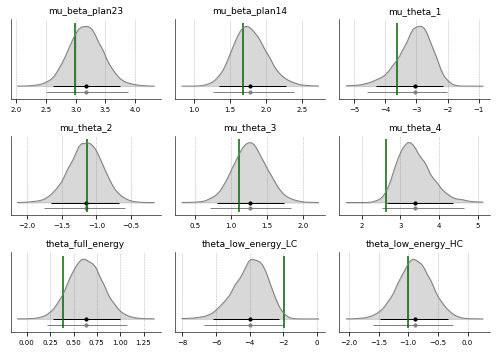

In [41]:
param_names_tmp = ['mu_beta_dv_23','mu_beta_dv_14','mu_theta_basic_1','mu_theta_basic_2','mu_theta_basic_3','mu_theta_basic_4','theta_full_energy','theta_low_energy_LC','theta_low_energy_HC']
param_labels = ['mu_beta_plan23','mu_beta_plan14','mu_theta_1','mu_theta_2','mu_theta_3','mu_theta_4','theta_full_energy','theta_low_energy_LC','theta_low_energy_HC']

fig, ax = plt.subplots(3,3, figsize = (7,5))
for i in range(len(param_names_tmp)):
    axes = ax.flat[i]
    param = param_names_tmp[i]
    # Plot PDF
    kernel = stats.gaussian_kde(samples_rep[param])
    min_tmp = np.mean(samples_rep[param])+np.std(samples_rep[param])*4
    max_tmp = np.mean(samples_rep[param])-np.std(samples_rep[param])*4
    positions = np.linspace(start=min_tmp,stop=max_tmp,num=50)
    pdf_estimate = kernel(positions)
    pdf_estimate = pdf_estimate/ (np.max(pdf_estimate)) 
     
    axes.plot(positions,pdf_estimate,color='grey',linewidth=1)
    axes.fill_between(positions,pdf_estimate,0,alpha=0.3,color = 'grey')
    axes.scatter(summary_rep[param]['mean'],0,color='black',s=10)
    axes.hlines(xmin=summary_rep[param]['q2_5'],xmax=summary_rep[param]['q97_5'],y=0, color='black',linewidth=1)
    axes.scatter(summary_rep[param]['mean'],-0.1,color='grey',s=10)
    axes.hlines(xmin=summary_rep[param]['q1'],xmax=summary_rep[param]['q99'],y=-0.1, color='grey',linewidth=1)
    axes.vlines(summary_hybrid[param]['mean'],ymin=axes.get_ylim()[0],ymax=axes.get_ylim()[1],color='darkgreen')
    axes.set_title(param_labels[i])
    axes.set_yticks([])

plt.tight_layout()                           

Group parameters were recovered reasonably well. Most of the known group parameter values are within the 95% credibility interval of the re-estimated parameters' marginal posterior (black horizontal lines). Parameters mu_theta_4 and theta_low_energy_LC are within the 99% credibility interval (grey horizontal lines). 

## Plot posterior distributions of refitted participant-level parameters and known data generating participant-level  parameters.

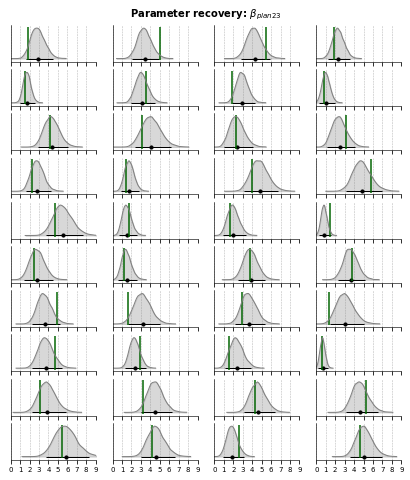

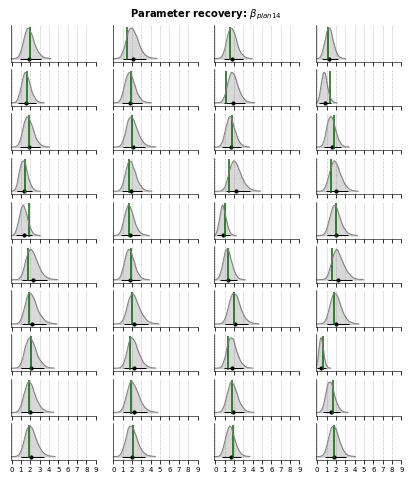

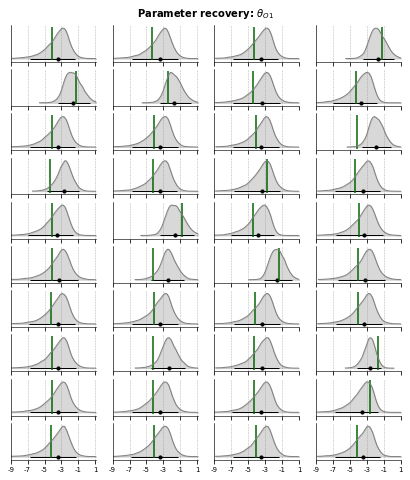

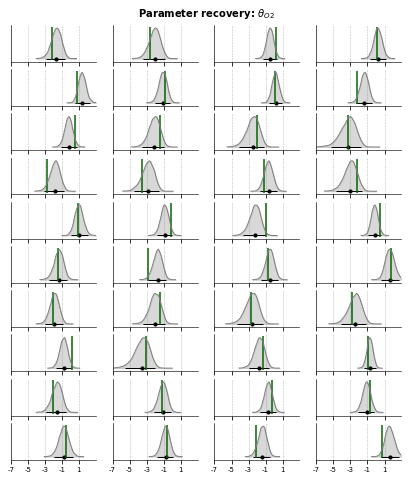

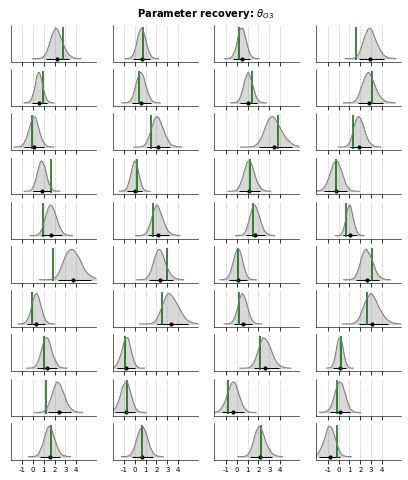

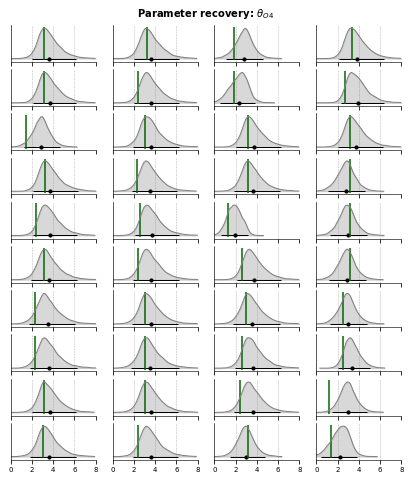

In [66]:
param_names_tmp = ['beta_dv_23','beta_dv_14','theta_basic_1','theta_basic_2','theta_basic_3','theta_basic_4']
param_labels = [r'$\beta_{plan23}$',r'$\beta_{plan14}$',r'$\theta_{O1}$',r'$\theta_{O2}$',r'$\theta_{O3}$',r'$\theta_{O4}$']

x_max = np.zeros(6)
x_min =np.zeros(6)
for i, param in enumerate(param_names_tmp): 
   x_max[i] = np.max(summary_rep[param]['q99'])
   x_min[i] =np.min(summary_rep[param]['q1'])

xticks = [np.arange(0,10,1),np.arange(0,10,1),  np.arange(-9,2,2), np.arange(-7,2,2), np.arange(-1,5,1), np.arange(0,9,2) ]
     
for i, param in enumerate(param_names_tmp): 
    fig, ax = plt.subplots(10,4, figsize = (7,8))
    for s,axes in enumerate(ax.flat):
        # Plot PDF
        kernel = stats.gaussian_kde(samples_rep[param][:,s])
        min_tmp = np.mean(samples_rep[param][:,s])+np.std(samples_rep[param][:,s])*4
        max_tmp = np.mean(samples_rep[param][:,s])-np.std(samples_rep[param][:,s])*4
        positions = np.linspace(start=min_tmp,stop=max_tmp,num=50)
        pdf_estimate = kernel(positions)
        pdf_estimate = pdf_estimate/ (np.max(pdf_estimate)) 
        
        axes.plot(positions,pdf_estimate,color='grey',linewidth=1)
        axes.fill_between(positions,pdf_estimate,0,alpha=0.3,color = 'grey')
        axes.scatter(summary_rep[param]['mean'][s],0,color='black',s=10)
        axes.hlines(xmin=summary_rep[param]['q2_5'][s],xmax=summary_rep[param]['q97_5'][s],y=0, color='black',linewidth=1)
        axes.vlines(summary_hybrid[param]['mean'][s],ymin=axes.get_ylim()[0],ymax=axes.get_ylim()[1],color='darkgreen')

        
        axes.set_yticks([])
        axes.set_xlim(x_min[i],x_max[i])
        axes.set_xticks(xticks[i])
        if s >= 36:
            axes.set_xticklabels(xticks[i])
        else:
            axes.set_xticklabels([])             
        if s == 0:
            axes.text(2.3,1.3,'Parameter recovery: '+param_labels[i],transform=axes.transAxes,horizontalalignment='center',verticalalignment='center',fontsize=10,fontweight='bold')
           

Participant-level parameters were recovered reasonably well. More than 95% of the known participant-level parameter values are within the 95% credibility interval of the re-estimated parameters' marginal posterior. One subplot corresponds to one of the 40 participants.